In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from importlib import reload
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib
import graphviz
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
pd.options.display.max_rows = 99
import ReadFromDB as RDB

In [66]:
def station_function(i):
    """
    Creates a sparse matrix from station information on database
    """
    
    station = RDB.add_times(RDB.create_station_dictionary(i)[i])
    weather = RDB.weather_times(RDB.read_weather(i))
#     df = pd.merge(station, weather, left_on=['date', 'hour', 'first_half_hour', 'second_half_hour'], right_on=['date', 'hour', 'first_half_hour', 'second_half_hour'], how='inner')
#     df.drop_duplicates(subset='last_updated', inplace=True)
#     df.drop_duplicates(subset='time', inplace=True)
    df = pd.merge_asof(station, weather, left_on=['last_updated'], right_on=['time'], tolerance=600, direction='nearest')
    df = df.dropna()
    df = df.reset_index()
    df.drop('index', axis=1, inplace=True)
    
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weather_icons = ['partly-cloudy-day',
                     'partly-cloudy-night',
                     'clear-night',
                     'clear-day',
                     'fog',
                     'wind',
                     'cloudy',
                     'rain'
                    ]
    weather_cols = ['apparentTemperature',
                    'cloudCover',
                    'dewPoint',
                    'precipIntensity',
                    'precipProbability',
                    'pressure',
                    'windBearing',
                    'windGust',
                    'uvIndex',
                    'visibility'
                    ]
    
    for day in days:
        df[day] = 0
    
    for icon in weather_icons:
        df[icon] = 0
    
    for j in df.index:
        val = df.loc[j, 'day_x']
        for day in days:
            if val == day:
                df.loc[j, day] = 1
        
        icon_val = df.loc[j, 'icon']
        for icon in weather_icons:
            if icon_val == icon:
                df.loc[j, icon] = 1
     
    data = pd.DataFrame((df.Mon, df.Tue, df.Wed, df.Thu, df.Fri, df.Sat, df.Sun, df.hour_x)).T #df.first_half_hour, df.second_half_hour)).T
    
    for icon in weather_icons:
        data[icon] = df[icon]
    for col in weather_cols:
        data[col] = df[col]
   
    label = pd.DataFrame((df.available_bikes))
    
    return [df, data, label]

In [67]:
%%time
[station, data, label] = station_function(2)

Wall time: 18.4 s


In [68]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, shuffle=False)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Wall time: 12 ms


In [80]:
def model(param, dtrain, dtest, num_round, cv_fold, early_stopping_rounds):
    model = xgb.train(param, dtrain, num_round, early_stopping_rounds=early_stopping_rounds, evals=[(dtest, 'Test')], verbose_eval=0)
    cv_result = xgb.cv(param, dtrain, num_round, nfold=cv_fold, early_stopping_rounds=early_stopping_rounds)
    predictions = model.predict(xgb.DMatrix(X_test))
    
    print("\nModel Report\n")
    print("\tMAE:", metrics.mean_absolute_error(y_test.values, predictions))
    print("\tMSE:", metrics.mean_squared_error(y_test.values, predictions))
    print("\tRMSE:", np.sqrt(metrics.mean_squared_error(y_test.values, predictions)))
    print("\tR2 Score:", metrics.r2_score(y_test.values, predictions))
    print("\tMinimum CV RMSE (train / test)", cv_result['train-rmse-mean'].min(), cv_result['test-rmse-mean'].min())
    print()
    rmse.append(np.sqrt(metrics.mean_squared_error(y_test.values, predictions)))
    cvs.append(cv_result['test-rmse-mean'].min())
    return model, cv_result

def plot_feature_importance(model):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,30))
    xgb.plot_importance(model, ax=ax1, height=0.2, importance_type='weight')
    xgb.plot_importance(model, ax=ax2, height=0.2, importance_type='cover')
    xgb.plot_importance(model, ax=ax3, height=0.2, importance_type='gain')
    ax1.set_title('Feature importance (importance_type=\'weight\')')
    ax2.set_title('Feature importance (importance_type=\'cover\')')
    ax3.set_title('Feature importance (importance_type=\'gain\')')

## Parameter Tuning
Tune parameters of the model, starting with default values

In [70]:
param = {
        'tree_method':'gpu_hist',
        'max_depth':6,
        'eta':0.3,
        'subsample':1,
        'gamma':0,
        'min_child_weight':1,
        'scale_pos_weight':1,
        'colsample_bytree':1,
    }

In [71]:
%%time

m, cv = model(param, dtrain, dtest, 1000, 5, 50)


Model Report

	MAE: 2.735731702450035
	MSE: 13.33273476415059
	RMSE: 3.651401753320304
	R2 Score: 0.6170871739739102
	Minimum CV RMSE (train / test) 0.2278436 1.203632

Wall time: 44.4 s


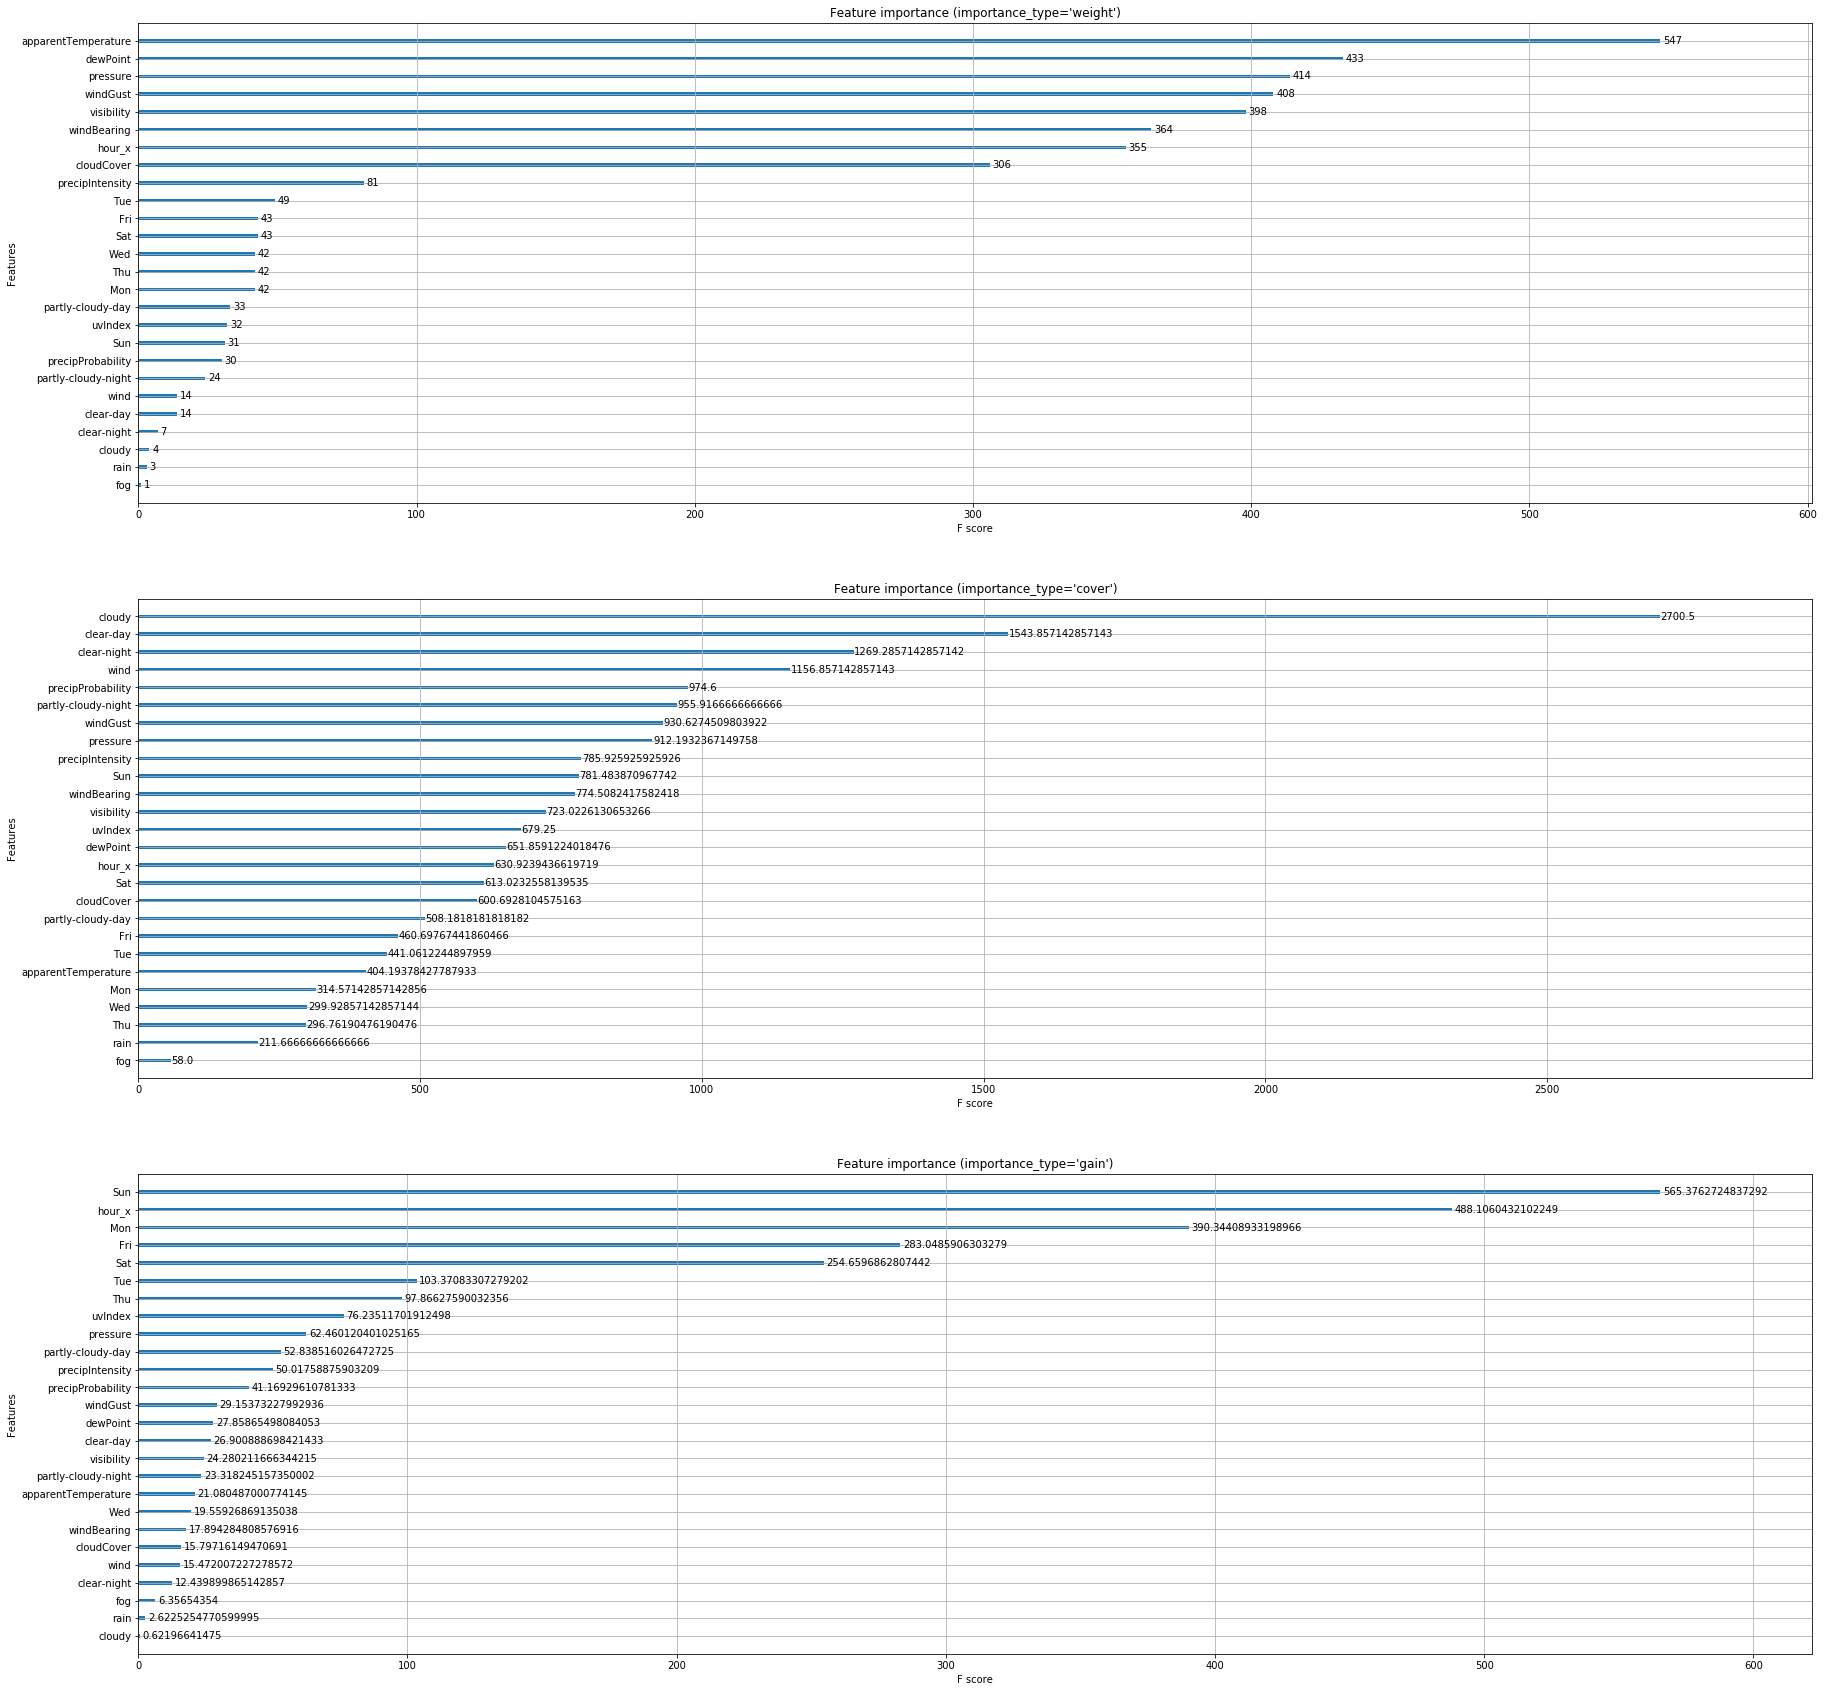

In [72]:
plot_feature_importance(m)

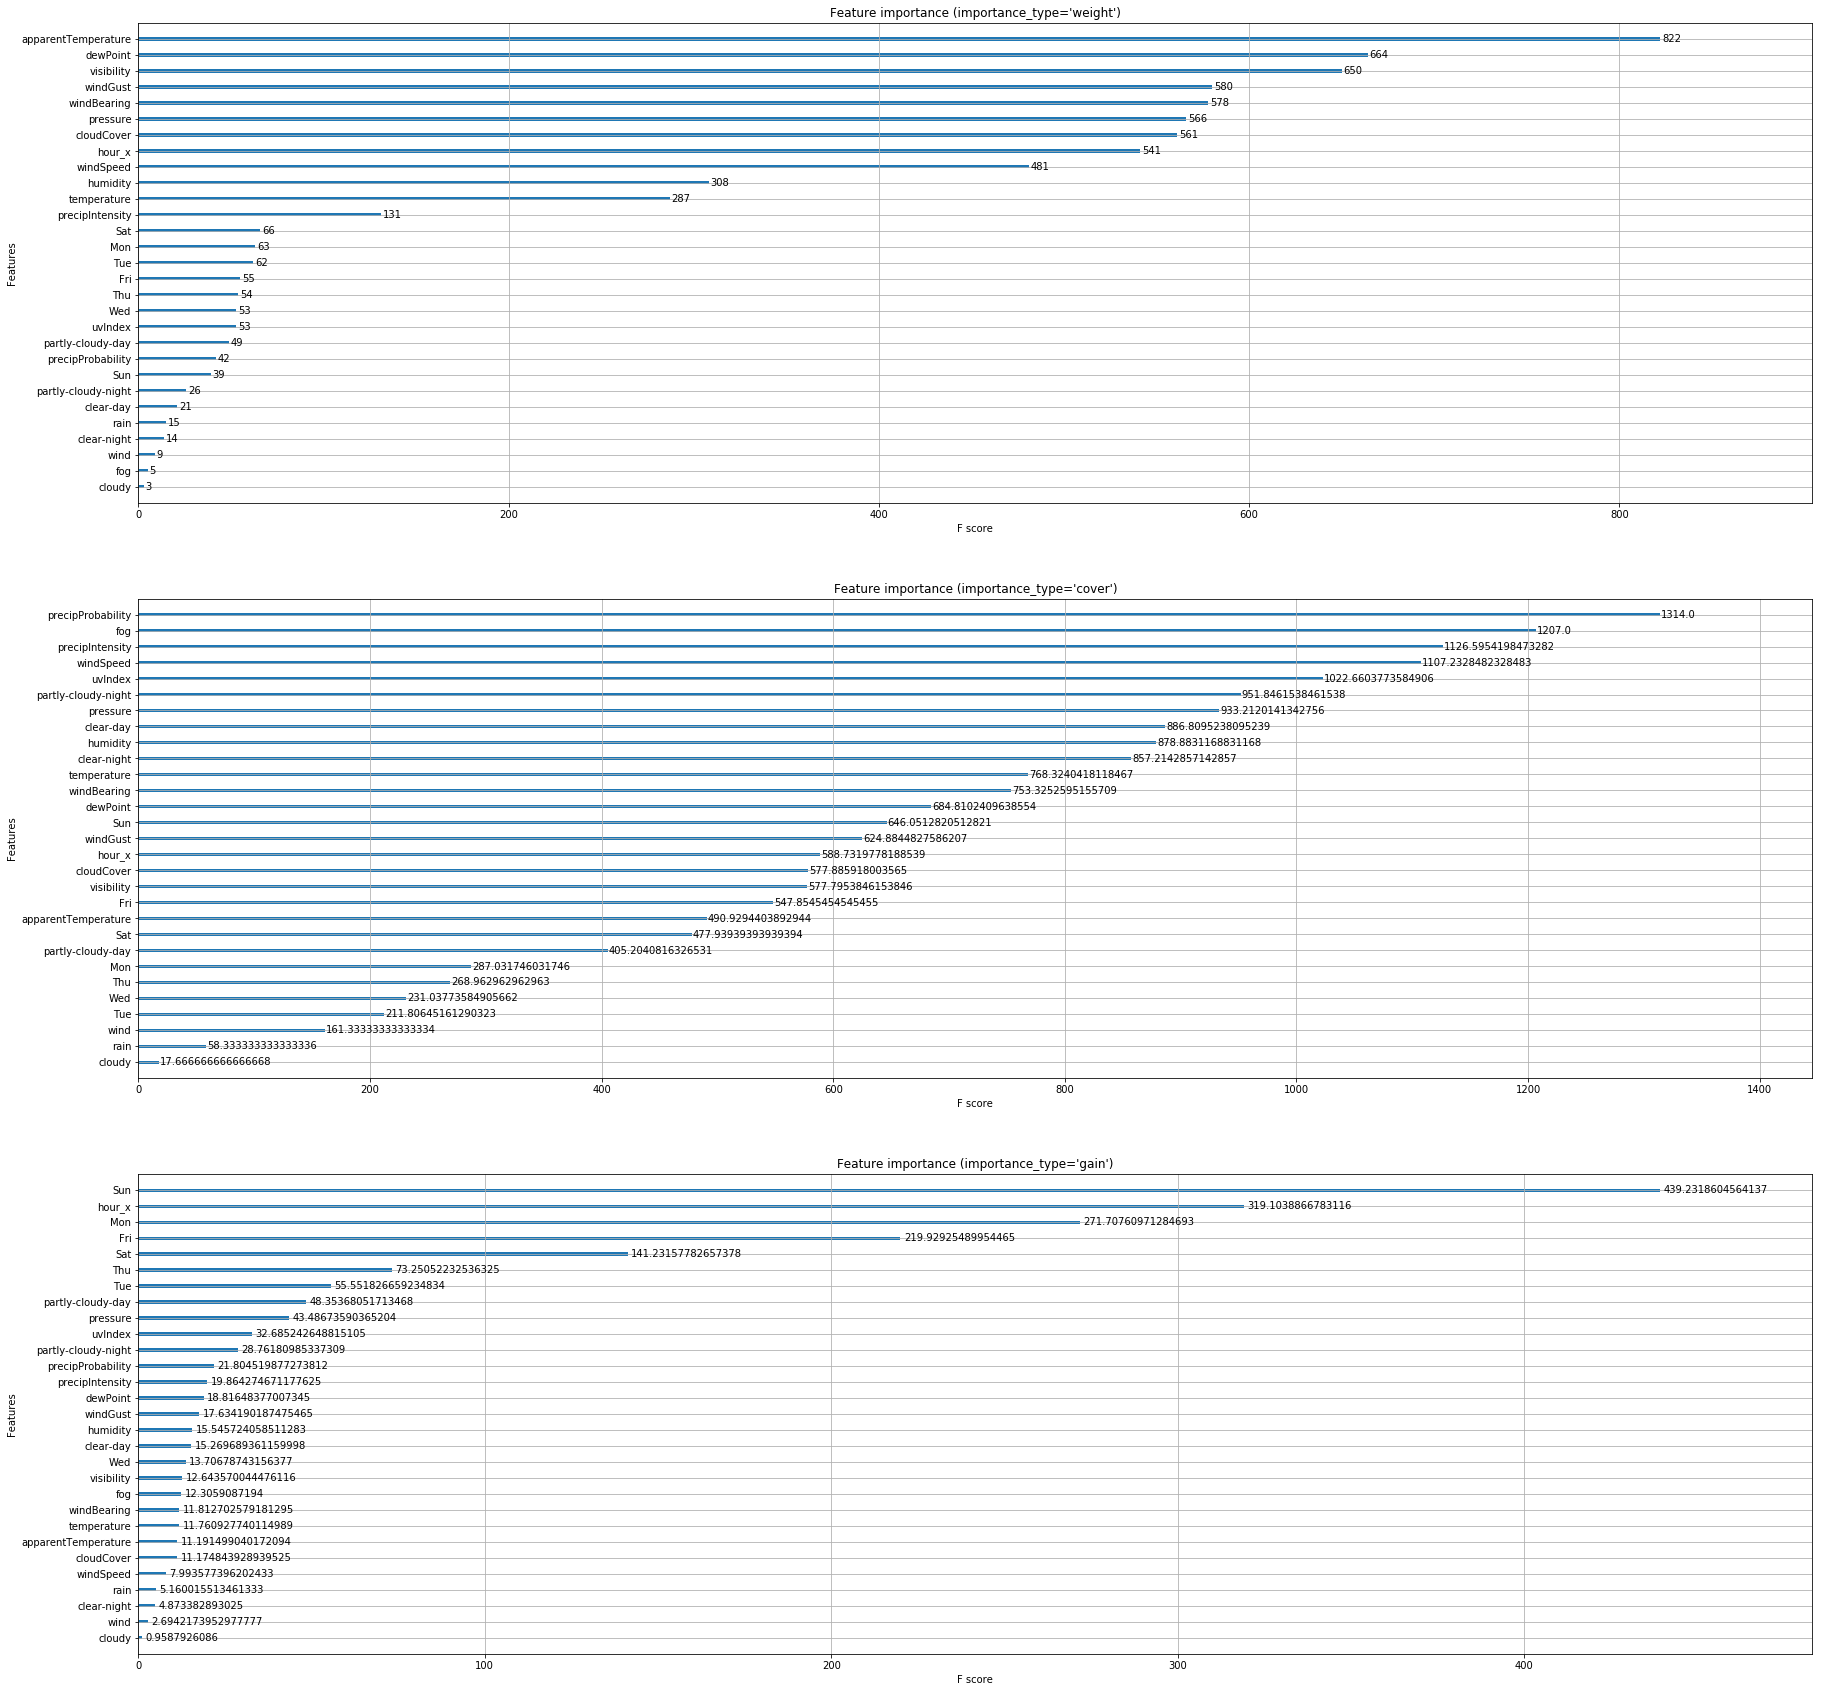

In [65]:
plot_feature_importance(m)

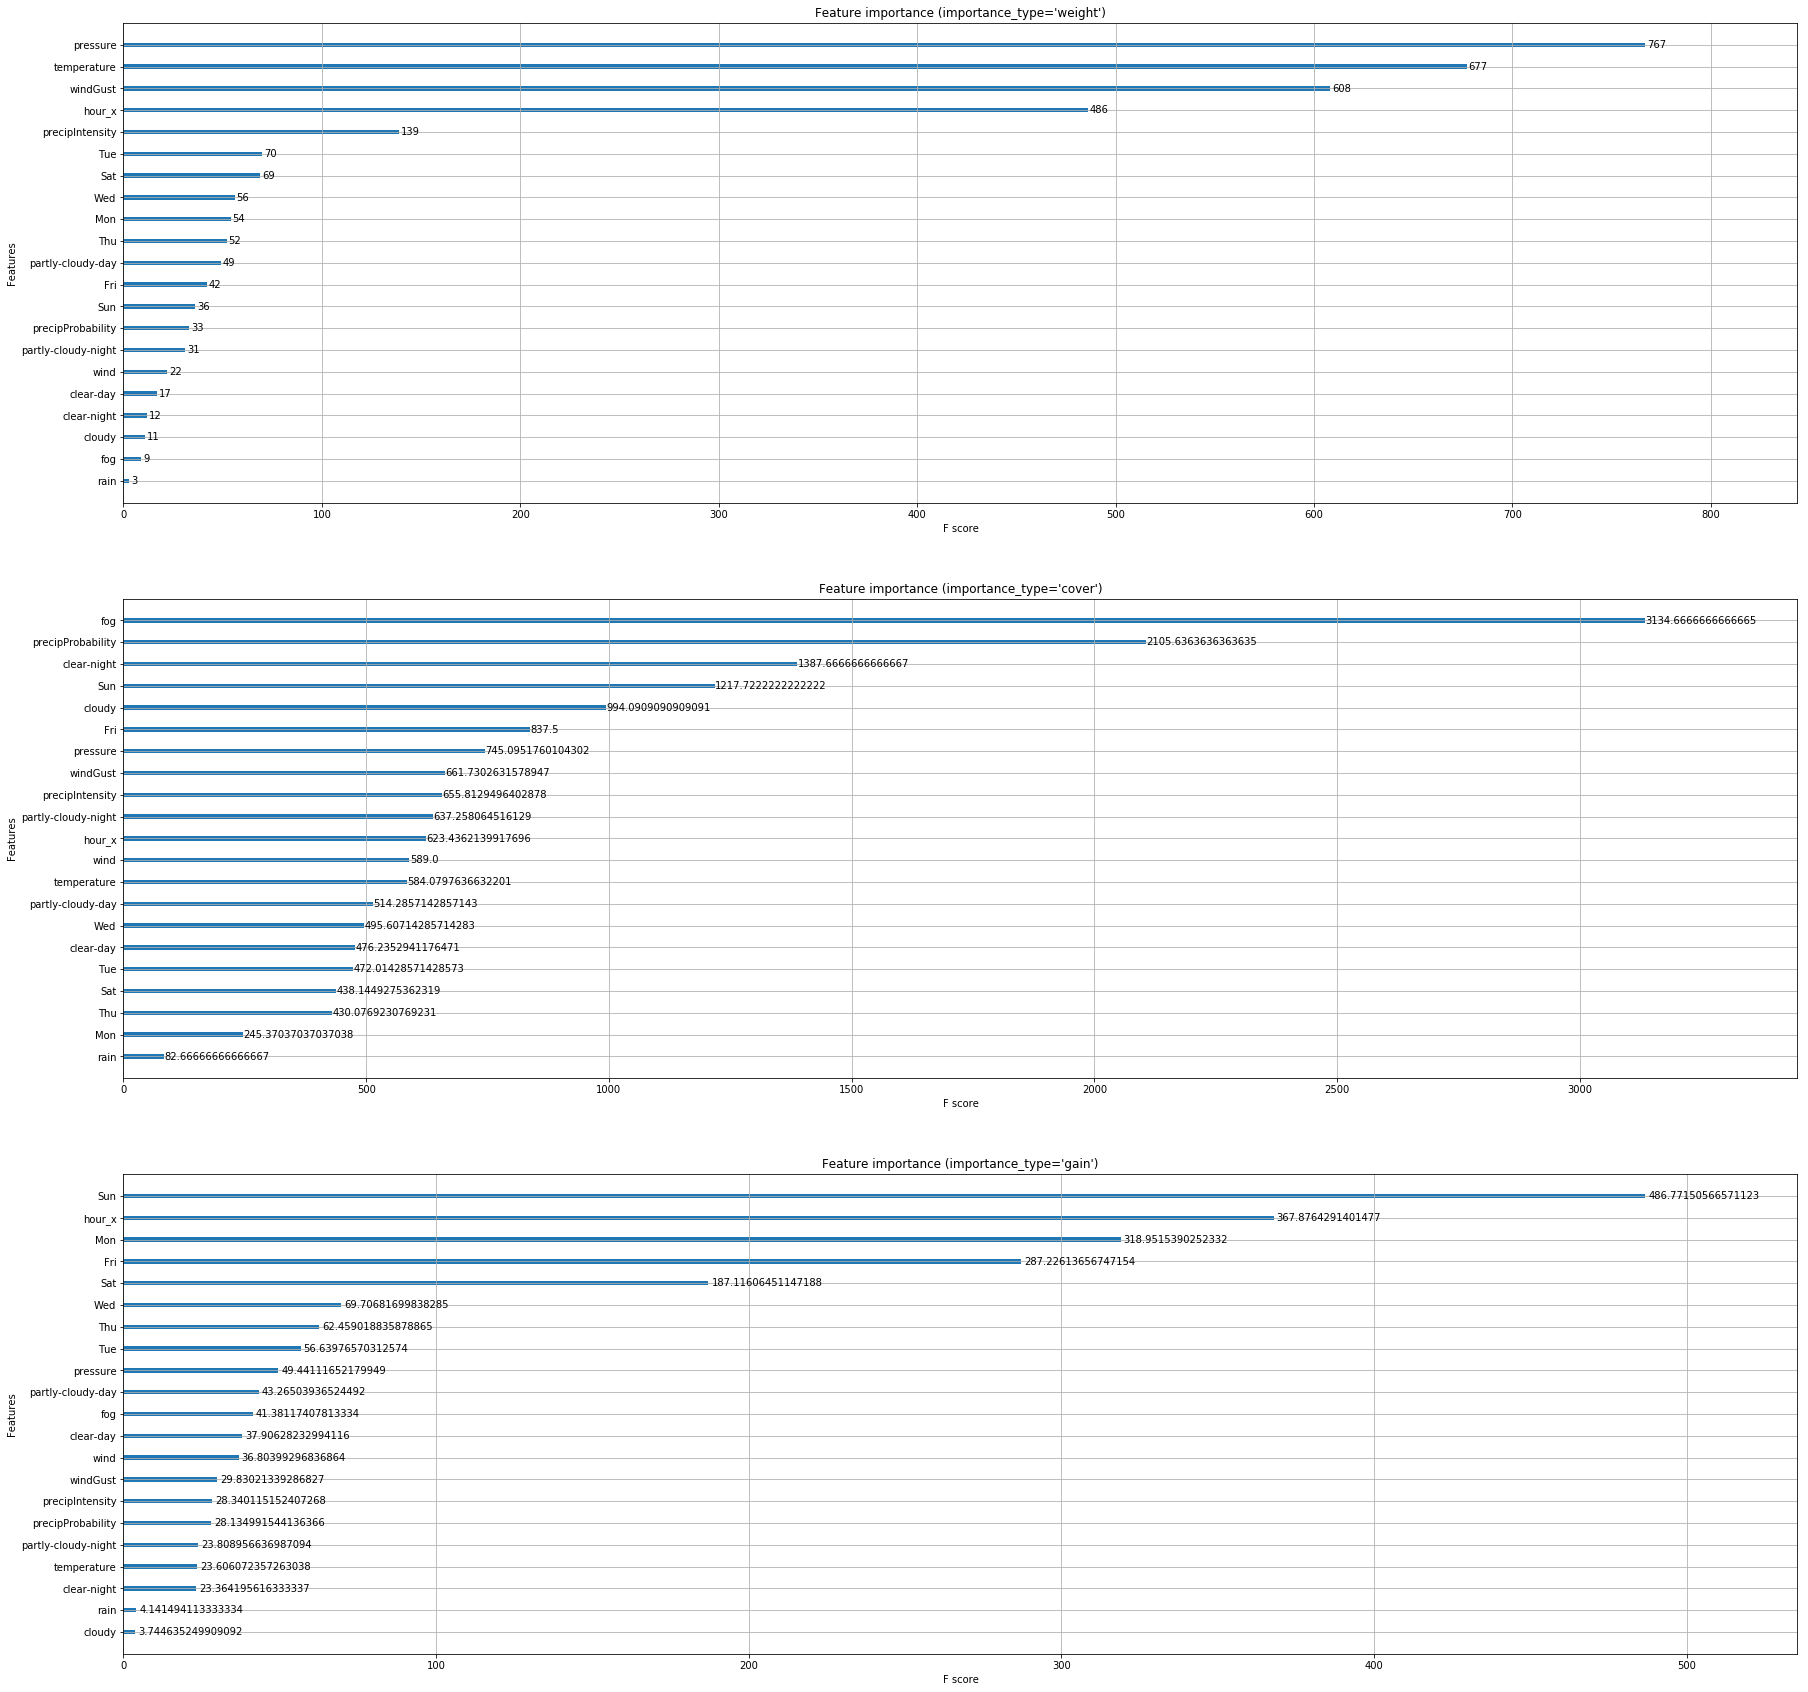

In [57]:
plot_feature_importance(m)

In [27]:
print("R2 Score:", metrics.r2_score(y_test.values, m.predict(xgb.DMatrix(X_test))))

R2 Score: 0.569665902161049


In [20]:
param = {
        'tree_method':'gpu_hist',
        'max_depth':5,
        'eta':0.1,
        'subsample':0.8,
        'gamma':0,
        'min_child_weight':1,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
    }

In [22]:
m1, cv1 = model(param, dtrain, dtest, 1000, 5, 50)


Model Report

	MAE: 2.7423894902218304
	MSE: 14.462110997067876
	RMSE: 3.8029082288516873
	Minimum CV RMSE (train / test) 0.30786600000000003 1.1280116


In [26]:
print("R2 Score:", metrics.r2_score(y_test.values, m1.predict(xgb.DMatrix(X_test))))

R2 Score: 0.5896338272100775


In [23]:
param = {
        'tree_method':'gpu_hist',
        'max_depth':5,
        'eta':0.1,
        'subsample':0.8,
        'gamma':0,
        'min_child_weight':5,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
    }

In [24]:
%%time
m2, cv2 = model(param, dtrain, dtest, 1000, 5, 50)


Model Report

	MAE: 2.6895798746765505
	MSE: 13.61296616976586
	RMSE: 3.6895753373207953
	Minimum CV RMSE (train / test) 0.3501146 1.1300561999999998
Wall time: 1min 8s


In [25]:
print("R2 Score:", metrics.r2_score(y_test.values, m2.predict(xgb.DMatrix(X_test))))

R2 Score: 0.6137285332315523


## max_depth

Test max_depth = [3, 4, 5, 6, 7, 8, 9]

In [36]:
%%time
max_depth = [i for i in range(3,10)]


for i in max_depth:
    param = {
        'tree_method':'gpu_hist',
        'max_depth':i,
        'eta':0.1,
        'subsample':0.8,
        'gamma':0,
        'min_child_weight':5,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
    }
    m3, cv3 = model(param, dtrain, dtest, 1000, 5, 50)

max_depth: 3

Model Report

	MAE: 2.633966342402499
	MSE: 12.948398609229434
	RMSE: 3.598388334967397
	R2 Score: 0.6325858111512805
	Minimum CV RMSE (train / test) 0.8622806000000001 1.377647

max_depth: 4

Model Report

	MAE: 2.7566757322866704
	MSE: 13.739474811268947
	RMSE: 3.7066797556936244
	R2 Score: 0.6101388175220683
	Minimum CV RMSE (train / test) 0.5292492 1.2087198000000001

max_depth: 5

Model Report

	MAE: 2.6895798746765505
	MSE: 13.61296616976586
	RMSE: 3.6895753373207953
	R2 Score: 0.6137285332315523
	Minimum CV RMSE (train / test) 0.3501146 1.1300561999999998

max_depth: 6

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

max_depth: 7

Model Report

	MAE: 2.6687694180837247
	MSE: 13.083385913604388
	RMSE: 3.617096337340822
	R2 Score: 0.6287555111706755
	Minimum CV RMSE (train / test) 0.24214659999999996 1.0977960000000002

max_depth: 8

Model Repor

## Setting max_depth = 6

Next determine optimal value for gamma in range [0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [43]:
%%time
gamma = [i/10.0 for i in range(6)]


for i in gamma:
    param = {
        'tree_method':'gpu_hist',
        'max_depth':6,
        'eta':0.1,
        'subsample':0.8,
        'gamma':i,
        'min_child_weight':5,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
    }
    m3, cv3 = model(param, dtrain, dtest, 1000, 5, 50)

gamma: 0.0

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

gamma: 0.1

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

gamma: 0.2

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

gamma: 0.3

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

gamma: 0.4

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

gamma: 0.5

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMS

## Set gamma = 0

No difference in different values for gamma so choosing 0 for simplicity. Next, determine value for subsample in range [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [46]:
%%time
subsample = [i/10.0 for i in range(5,11)]


for i in subsample:
    param = {
        'tree_method':'gpu_hist',
        'max_depth':6,
        'eta':0.1,
        'subsample':i,
        'gamma':0,
        'min_child_weight':5,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
    }
    m3, cv3 = model(param, dtrain, dtest, 1000, 5, 50)

subsample: 0.5

Model Report

	MAE: 2.6757602086061874
	MSE: 13.318110486984375
	RMSE: 3.6493986473094955
	R2 Score: 0.6220951401600241
	Minimum CV RMSE (train / test) 0.3072752 1.1190858000000001

subsample: 0.6

Model Report

	MAE: 2.6585369656446347
	MSE: 13.074818490637231
	RMSE: 3.6159118477414838
	R2 Score: 0.6289986140326587
	Minimum CV RMSE (train / test) 0.28336939999999994 1.1155438

subsample: 0.7

Model Report

	MAE: 2.6809655287686516
	MSE: 13.4637098019128
	RMSE: 3.6692928204100586
	R2 Score: 0.6179637216112295
	Minimum CV RMSE (train / test) 0.28959419999999997 1.1178344

subsample: 0.8

Model Report

	MAE: 2.6509558021667194
	MSE: 13.031542502708612
	RMSE: 3.6099227834828564
	R2 Score: 0.6302265814810879
	Minimum CV RMSE (train / test) 0.262208 1.1051954

subsample: 0.9

Model Report

	MAE: 2.736243174001519
	MSE: 14.087457813248795
	RMSE: 3.7533262332561494
	R2 Score: 0.6002647090501192
	Minimum CV RMSE (train / test) 0.2558062 1.1012844

subsample: 1.0

Model Report



## Set subsample = 0.8


In [73]:
%%time
[station, data, label] = station_function(3)

Wall time: 19.4 s


In [76]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, shuffle=False)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
        'tree_method':'gpu_hist',
        'max_depth':6,
        'eta':0.1,
        'subsample':0.8,
        'gamma':0,
        'min_child_weight':5,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
}
m3, cv3 = model(param, dtrain, dtest, 1000, 5, 50)


Model Report

	MAE: 4.063052218412475
	MSE: 31.66308610118513
	RMSE: 5.626996188126053
	R2 Score: -0.3026108206484319
	Minimum CV RMSE (train / test) 0.3372834 1.0612058

Wall time: 1min 17s


In [78]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, shuffle=False)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
        'tree_method':'gpu_hist',
        'max_depth':6,
        'eta':0.1,
        'subsample':0.8,
        'gamma':0,
        'min_child_weight':5,
        'scale_pos_weight':1,
        'colsample_bytree':0.8,
}
m3, cv3 = model(param, dtrain, dtest, 1000, 5, 50)


Model Report

	MAE: 4.714636621867163
	MSE: 40.574242134694636
	RMSE: 6.369791372933233
	R2 Score: -0.5474778337042019
	Minimum CV RMSE (train / test) 0.3333036 1.067702

Wall time: 1min 26s


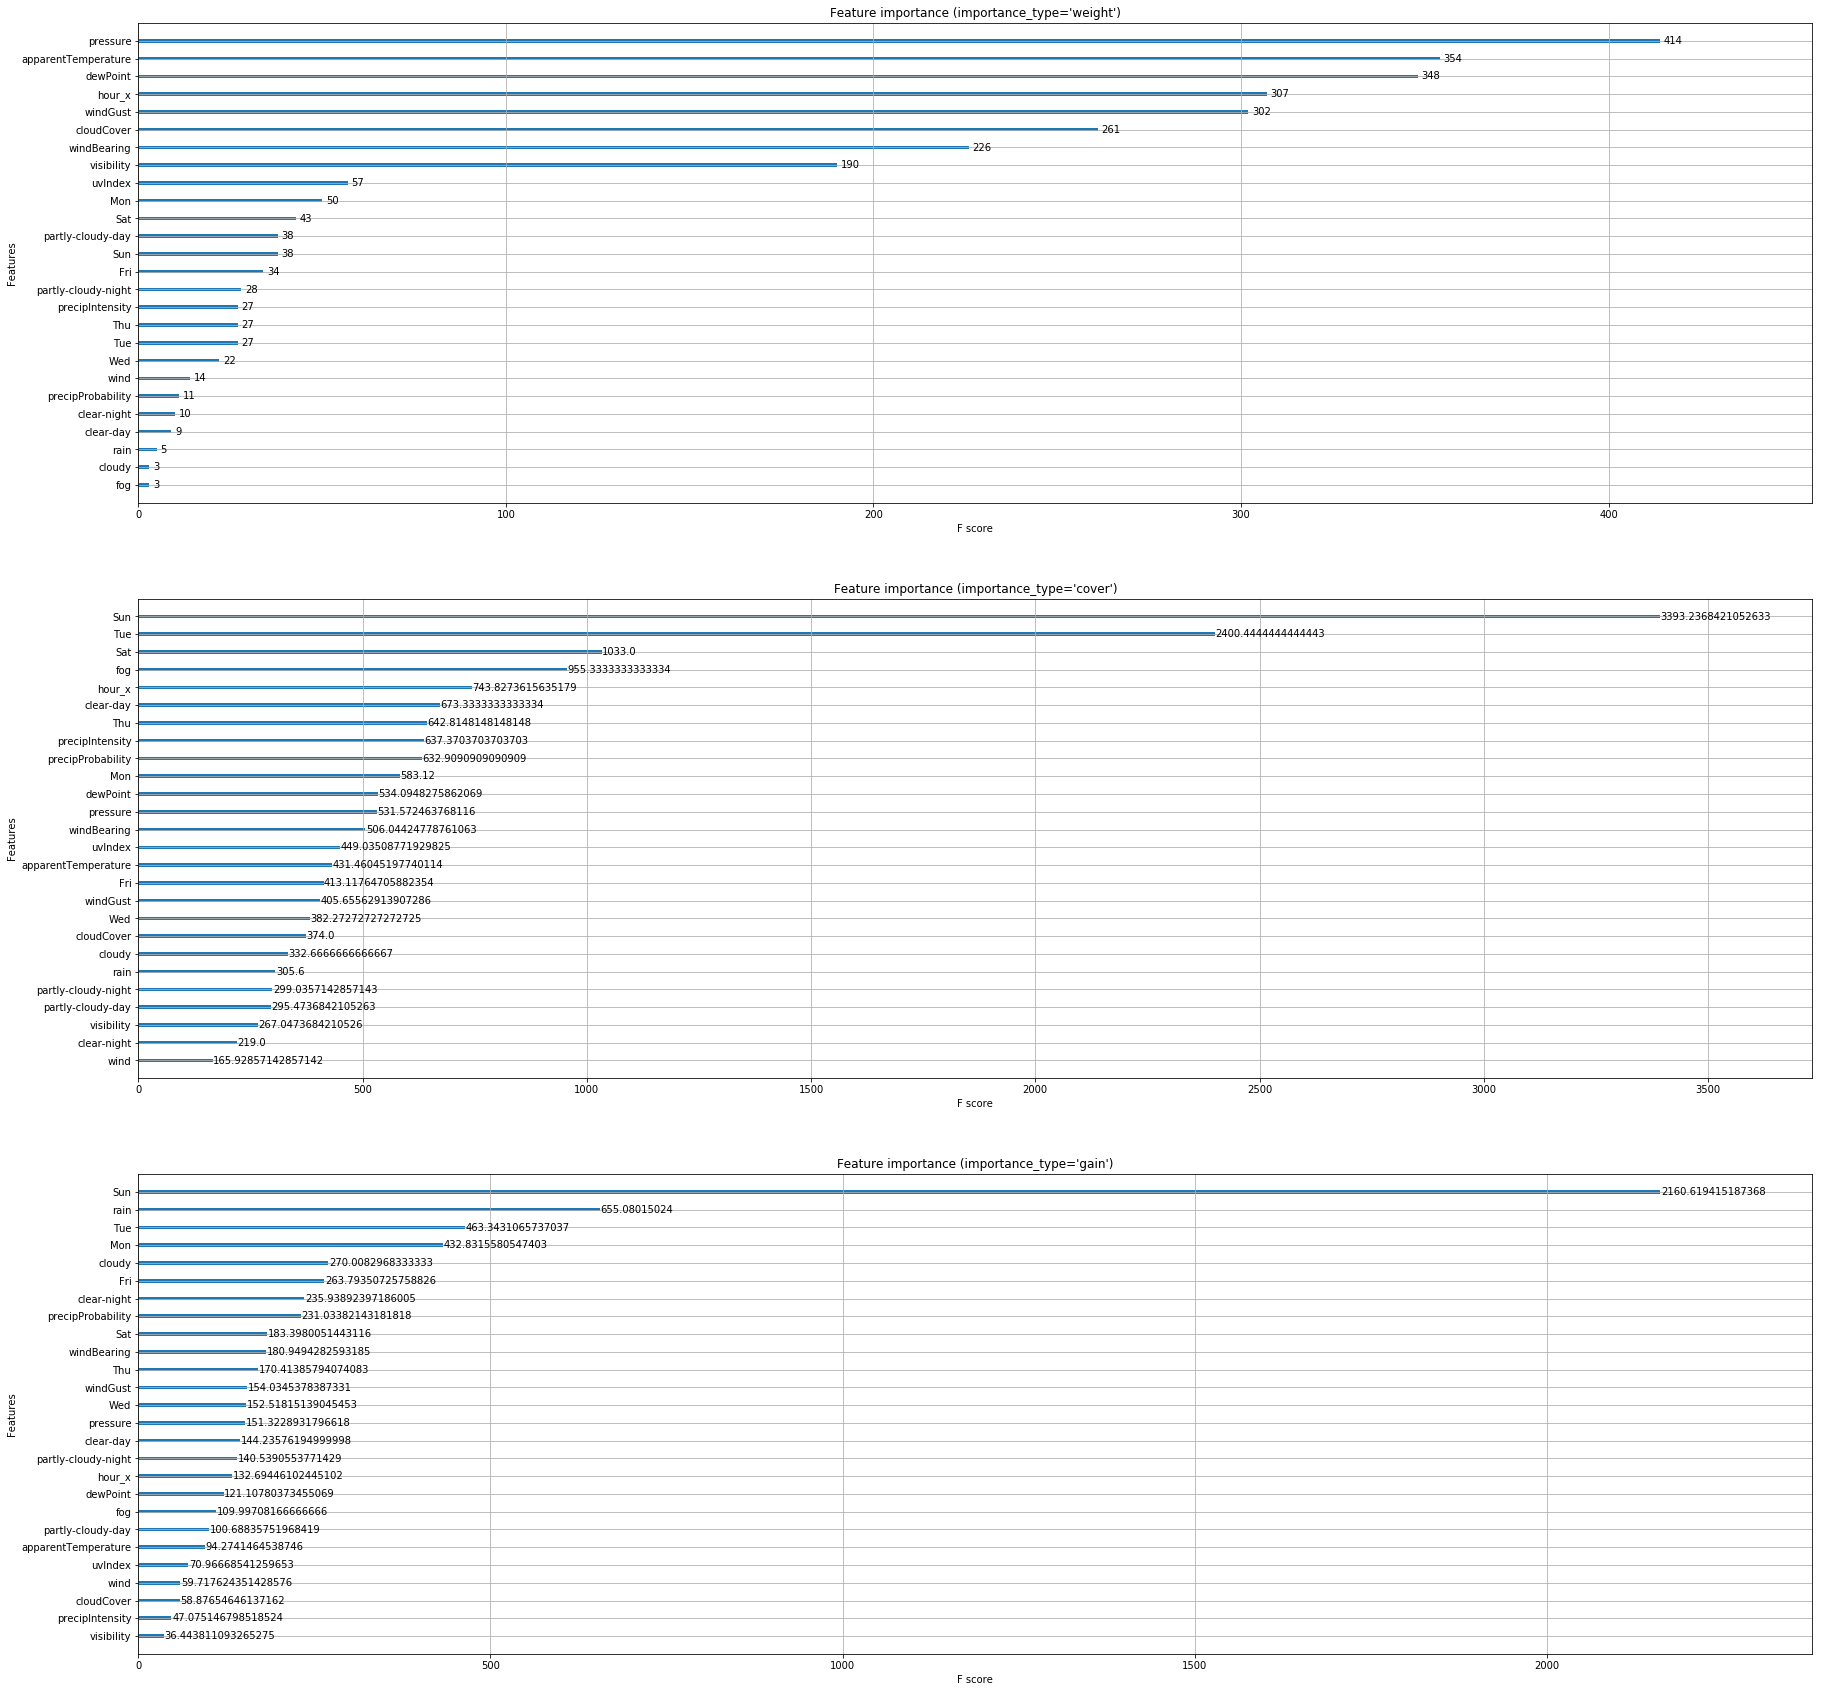

In [77]:
plot_feature_importance(m3)

In [85]:
%%time
rmse = []
cvs = []
def create_model(station_num):
    print("\nOn station", station_num)
    [station, data, label] = station_function(station_num)
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, shuffle=False)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    param = {
            'tree_method':'gpu_hist',
            'max_depth':6,
            'eta':0.1,
            'subsample':0.8,
            'gamma':0,
            'min_child_weight':5,
            'scale_pos_weight':1,
            'colsample_bytree':0.8,
    }
    mdl, cv = model(param, dtrain, dtest, 1000, 5, 50)
    mdl.save_model('xgbmodels/gpu_hist_v3/station_{}.model'.format(station_num))
    mdl.dump_model('xgbmodels/dump_v3/dump_{}.raw.txt'.format(station_num))
    return model

Wall time: 0 ns


In [87]:
%%time
for i in range(2, 116):
    if not i==20:
        create_model(i)


On station 2

Model Report

	MAE: 5.01739294936761
	MSE: 42.03729701319352
	RMSE: 6.483617586902664
	R2 Score: -0.603277889967825
	Minimum CV RMSE (train / test) 0.29944820000000005 1.1242228


On station 3

Model Report

	MAE: 4.643927638600663
	MSE: 39.908184991508044
	RMSE: 6.317292536483334
	R2 Score: -0.5220748043231493
	Minimum CV RMSE (train / test) 0.31359159999999997 1.064498


On station 4

Model Report

	MAE: 4.408925931458584
	MSE: 31.494196747142542
	RMSE: 5.611969061491924
	R2 Score: -0.20117022012958086
	Minimum CV RMSE (train / test) 0.29889679999999996 0.8782186


On station 5

Model Report

	MAE: 9.384904268331125
	MSE: 125.24187822373203
	RMSE: 11.191151782713522
	R2 Score: -3.7766518906087496
	Minimum CV RMSE (train / test) 0.720383 2.5506396000000002


On station 6

Model Report

	MAE: 4.595334691126382
	MSE: 30.877412086344318
	RMSE: 5.556744738274768
	R2 Score: -0.17764641437159545
	Minimum CV RMSE (train / test) 0.29172300000000007 0.9904752


On station 7

Mod


Model Report

	MAE: 7.832686836039711
	MSE: 95.33146559649283
	RMSE: 9.763783364889495
	R2 Score: -2.635886269307829
	Minimum CV RMSE (train / test) 0.2354206 1.0385066


On station 46

Model Report

	MAE: 6.004689377090941
	MSE: 54.961032533874814
	RMSE: 7.413570835560608
	R2 Score: -1.0961815942568278
	Minimum CV RMSE (train / test) 0.3444 1.0597518000000001


On station 47

Model Report

	MAE: 11.76134559579224
	MSE: 246.56113328366553
	RMSE: 15.702265227783714
	R2 Score: -8.403697230938588
	Minimum CV RMSE (train / test) 0.40025179999999994 1.7700413999999998


On station 48

Model Report

	MAE: 15.815153341664136
	MSE: 354.1942512378169
	RMSE: 18.820049182662007
	R2 Score: -12.508761317005531
	Minimum CV RMSE (train / test) 0.48175 1.7543246


On station 49

Model Report

	MAE: 12.25673895871005
	MSE: 228.09252574748038
	RMSE: 15.102732393427369
	R2 Score: -7.699315355197019
	Minimum CV RMSE (train / test) 0.5036312 2.0760454000000004


On station 50

Model Report

	MAE: 9.734899


Model Report

	MAE: 9.472876099597709
	MSE: 137.26115125989602
	RMSE: 11.71585042836823
	R2 Score: -4.235059925414607
	Minimum CV RMSE (train / test) 0.24998419999999996 1.2216226000000001


On station 88

Model Report

	MAE: 8.93168241291791
	MSE: 122.18752392713857
	RMSE: 11.053846567016324
	R2 Score: -3.6601606064446033
	Minimum CV RMSE (train / test) 0.30703739999999996 1.2285456


On station 89

Model Report

	MAE: 7.32219208711898
	MSE: 90.06034773869087
	RMSE: 9.490013052609088
	R2 Score: -2.43484892111258
	Minimum CV RMSE (train / test) 0.28392900000000004 1.4319608000000001


On station 90

Model Report

	MAE: 12.031509376828538
	MSE: 254.05528545535208
	RMSE: 15.939111815134245
	R2 Score: -8.689519805999693
	Minimum CV RMSE (train / test) 0.4028098 1.7182874


On station 91

Model Report

	MAE: 8.709682956073651
	MSE: 99.1154046007218
	RMSE: 9.955671981374326
	R2 Score: -2.7802034869577437
	Minimum CV RMSE (train / test) 0.4656728 1.7531272000000002


On station 92

Model Re

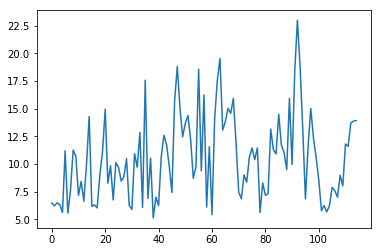

In [90]:
plt.plot(rmse)